# This notebook is my intermediate step toward creating a run script for `aggregate_MOHID.py`

In [2]:
import numpy as np
import pandas as pd
import gc
import os
import math
import pathlib
import xarray as xr
import sys
from matplotlib import pyplot as plt, cm, colors
from cmocean import cm as cmo
from datetime import datetime
from glob import glob
import yaml
#from tqdm.notebook import tqdm
sys.path.insert(
    0, 
    '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization/scripts'
)
from viz_MOHID_tools import get_MOHID_netcdf_filenames, aggregate_MOHID

%matplotlib inline
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 12})

In [3]:
# Results path
results_dir = '/scratch/dlatorne/MIDOSS/runs/monte-carlo'
# location of yaml file with runs dictionary sorted into oil types
yaml_dir = pathlib.Path(
    '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization'
)
# location to store aggregated netcdf
netcdf_dir = pathlib.Path(f'/scratch/rmueller/MIDOSS/Results') 

# NEMO meshmask
mask = xr.open_dataset(
    '/project/def-allen/rmueller/MEOPAR/grid/mesh_mask201702.nc'
)

oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]

# Specify surface level for depth slice
zlevel = 39
slc = {'grid_z': zlevel}

### Read in filepaths

In [3]:
%%time
filenames_yaml = yaml_dir / 'MOHID_results_locations_07102021_15:52:22.yaml'
with filenames_yaml.open("rt") as f:
    run_paths = yaml.safe_load(f)

CPU times: user 3.19 s, sys: 124 ms, total: 3.32 s
Wall time: 3.32 s


In [4]:
for oil in oil_types:
    print(f'{oil}: {len(run_paths[oil])} completed runs')

akns: 53 completed runs
bunker: 2498 completed runs
dilbit: 1 completed runs
jet: 20 completed runs
diesel: 4268 completed runs
gas: 57 completed runs
other: 52 completed runs


In [5]:
group_runs = 75
ngroups = 1
n_iter={}
for oil in oil_types:
    n_iter[oil]=len(run_paths[oil])/group_runs
    print(n_iter[oil])

0.7066666666666667
33.306666666666665
0.013333333333333334
0.26666666666666666
56.906666666666666
0.76
0.6933333333333334


In [6]:
for oil in oil_types:
    n_iter[oil]=math.ceil(len(run_paths[oil])/group_runs)
    print(n_iter[oil])

1
34
1
1
57
1
1


In [7]:
len(run_paths['akns'][0:99])

53

### Create aggregated file for all oil type

In [8]:
%%time
#------------------------------------------------------------
# set dimensions for netcdf
ny,nx = 896, 396
x, y = np.arange(0,nx), np.arange(0,ny)
# create threshold for surface and beach volume in m3
surface_threshold = 3e-3
beach_threshold = 15e-3
#------------------------------------------------------------
ngroups = 1 # for just one set of output.nc per oil type
for oil in oil_types: # loop through oils
    this_iter = 1
    while (this_iter <= ngroups) & (n_iter[oil]>=this_iter): # loop through specified number of groups
        first = (this_iter-1) * group_runs 
        last = this_iter*group_runs - 1
        print(f'{oil}_{this_iter}_of_{n_iter[oil]}, files{first}-{last}')
        #------------------------------------------------------------
        # define output netcdf name
        aggregated_netcdf = netcdf_dir / f'{oil}_runset{this_iter}.nc'
        aggregated_csv = netcdf_dir / f'{oil}_runset{this_iter}_filenames.csv'
        #------------------------------------------------------------
        # loop through and aggregate nruns in oil type
        # this code will need to be updated when loop through groups is 
        # introduced
        agg_out, files = aggregate_MOHID(
            run_paths[oil][first:last], 
            surface_threshold=3e-3, 
            beach_threshold=15e-3)
        # Save output to netcdf and a .csv file containing list of runs
        agg_out.to_netcdf(aggregated_netcdf, engine='h5netcdf')
        np.savetxt(aggregated_csv, files, delimiter =", ", fmt ='% s')
        this_iter += 1
        gc.collect()
        del agg_out

akns_1_of_1, files0-74
bunker_1_of_34, files0-74
dilbit_1_of_1, files0-74
jet_1_of_1, files0-74
diesel_1_of_57, files0-74
gas_1_of_1, files0-74
other_1_of_1, files0-74
CPU times: user 2min 1s, sys: 54.9 s, total: 2min 56s
Wall time: 3min 34s


### Plot results

In [ ]:
aggregated_netcdf = netcdf_dir / f'{oil}_runset{this_iter}.nc'
akns_runset1.nc

In [4]:
test_nc = xr.open_dataset(netcdf_dir / 'akns_runset1.nc')
[*test_nc]

['BeachPresence',
 'BeachPresence_one',
 'BeachPresence_seven',
 'BeachPresence_three',
 'Filenames',
 'MeanBeachTime',
 'MinBeachTime',
 'TotalBeachVolume']

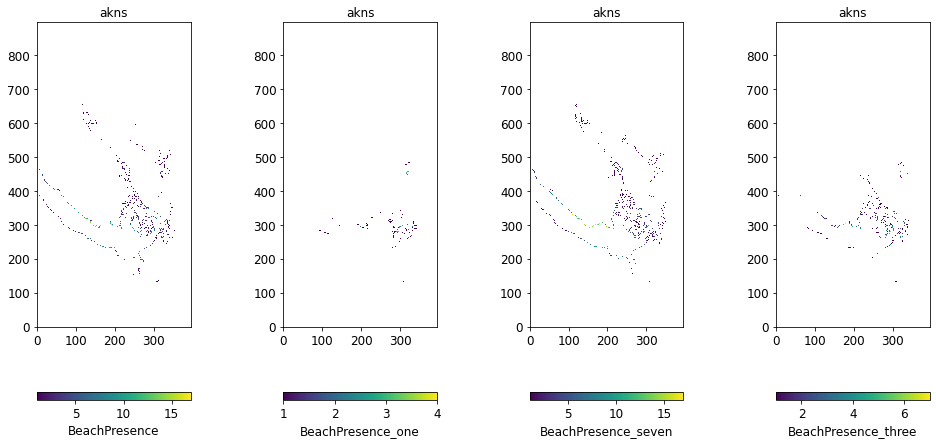

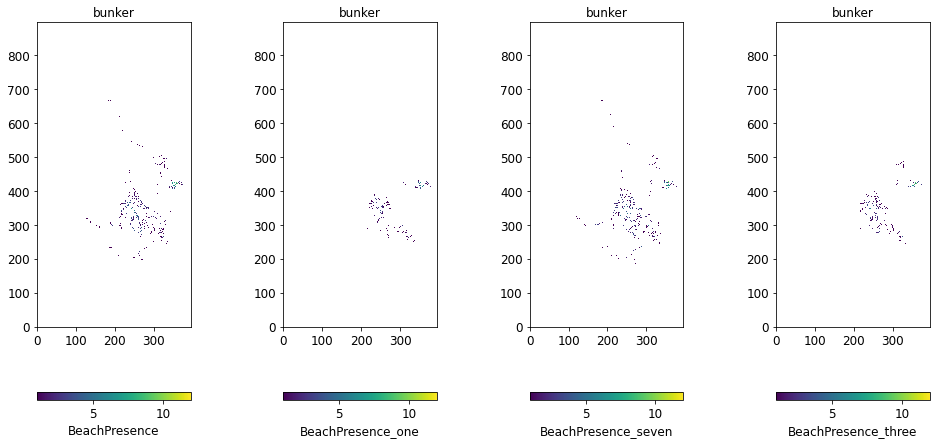

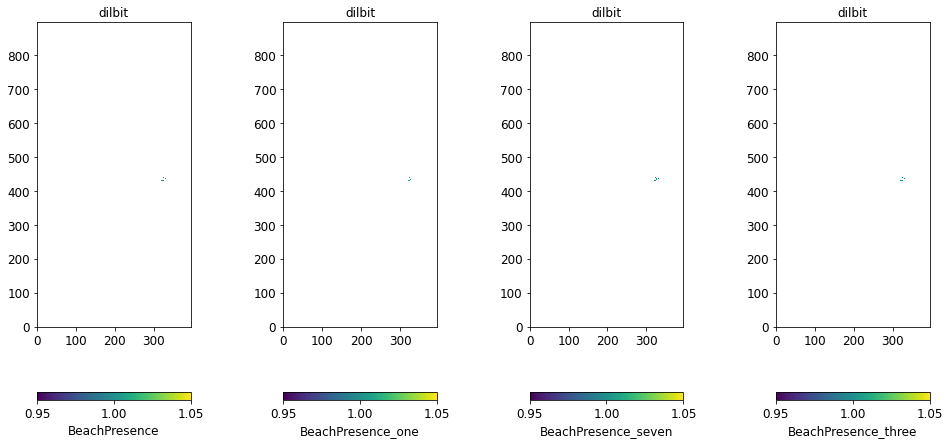

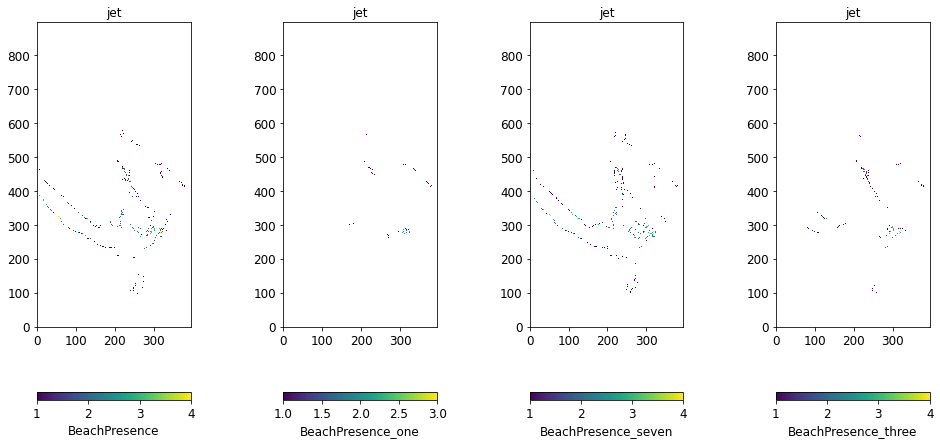

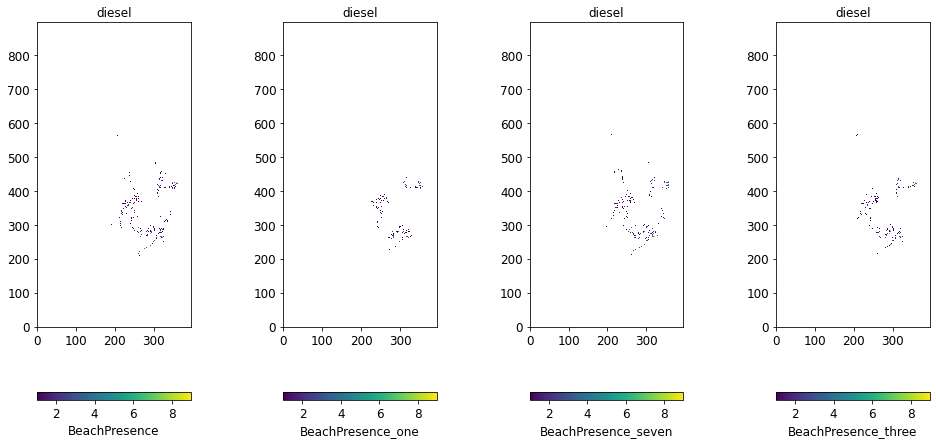

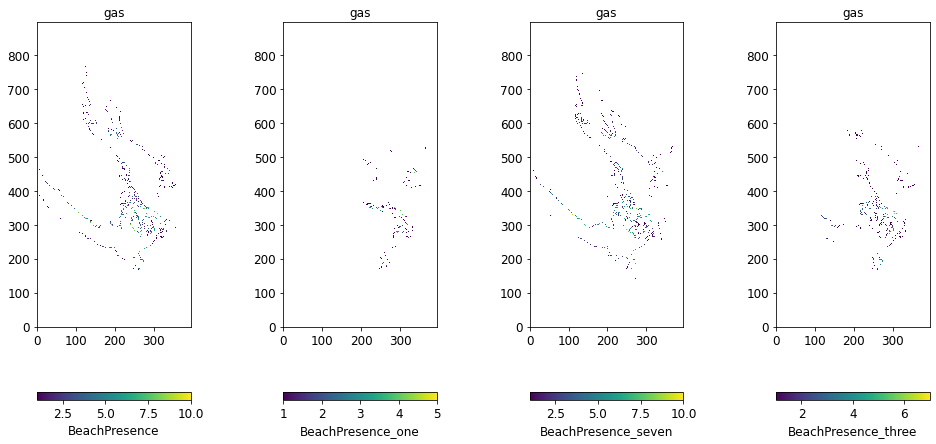

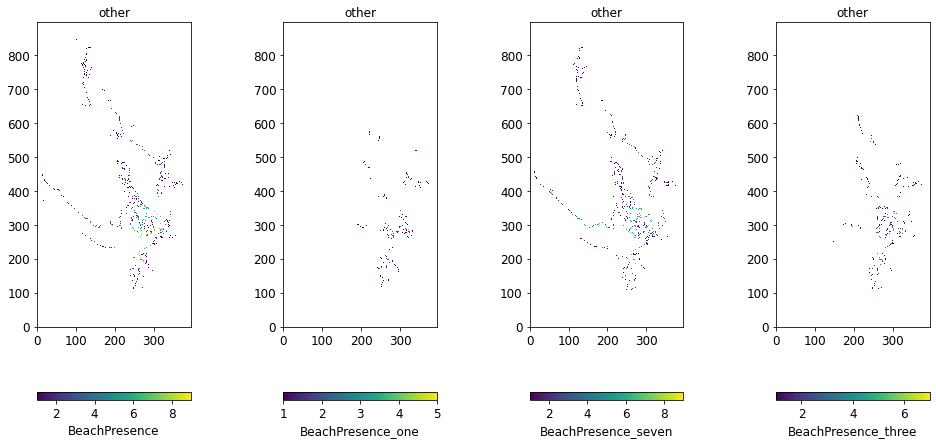

In [6]:
for oil in oil_types:
    aggregated_netcdf = netcdf_dir / f'{oil}_runset1.nc'
    test_nc = xr.open_dataset(aggregated_netcdf)
    fig, axs = plt.subplots(1, 4, figsize=(16, 8), gridspec_kw={'wspace': 0.6, 'hspace': 0.4})
    #print(oil)
    for idx,variable in enumerate([*test_nc][0:4]):
        test_nc[variable].where(test_nc[variable]>0,np.nan).plot(
            ax=axs[idx],
            cbar_kwargs={'orientation':'horizontal','spacing': 'proportional'}
        )
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('')
        axs[idx].set_title(oil)

### Create aggregated file for ANS

In [9]:
%%time
#------------------------------------------------------------
# set dimensions for netcdf
ny,nx = 896, 396
x, y = np.arange(0,nx), np.arange(0,ny)
# create threshold for surface and beach volume in m3
surface_threshold = 3e-3
beach_threshold = 15e-3
#------------------------------------------------------------
# "oil" will eventually be assigned in for-loop
oil = 'akns'
#------------------------------------------------------------
# This will become 100 or more
nruns = len(run_paths[oil])
#------------------------------------------------------------
# group number will be assigned by the N groups of files 
# created by dividing the total runs in each oil type by the 
# "nruns" processed here
group = 1
#------------------------------------------------------------
# define output netcdf name
aggregated_netcdf = netcdf_dir / f'{oil}_runset{group}.nc'
aggregated_csv = netcdf_dir / f'{oil}_runset{group}_filenames.csv'
#------------------------------------------------------------
# loop through and aggregate nruns in oil type
# this code will need to be updated when loop through groups is 
# introduced
agg_out, files = aggregate_MOHID(
    run_paths[oil], 
    surface_threshold=3e-3, 
    beach_threshold=15e-3)

CPU times: user 18.8 s, sys: 7.58 s, total: 26.4 s
Wall time: 31.5 s


In [10]:
# Save output to netcdf and a .csv file containing list of runs
agg_out.to_netcdf(aggregated_netcdf, engine='h5netcdf')
np.savetxt(aggregated_csv, files, delimiter =", ", fmt ='% s')

## read in the created netcdf to check format

In [11]:
test_nc = xr.open_dataset(netcdf_dir / aggregated_netcdf)
[*test_nc]

['BeachPresence',
 'BeachPresence_one',
 'BeachPresence_seven',
 'BeachPresence_three',
 'Filenames',
 'MeanBeachTime',
 'MinBeachTime',
 'TotalBeachVolume']

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

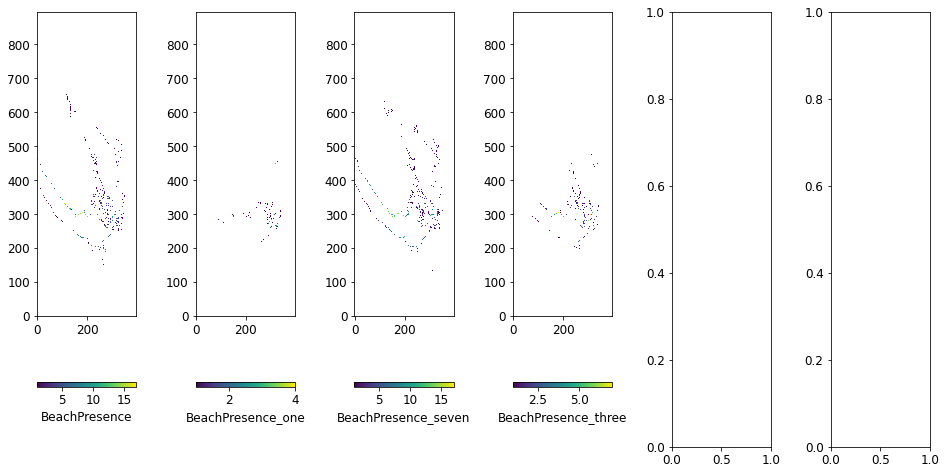

In [12]:
fig, axs = plt.subplots(1, 6, figsize=(16, 8), gridspec_kw={'wspace': 0.6, 'hspace': 0.4})
for idx,variable in enumerate([*test_nc]):
    test_nc[variable].where(test_nc[variable]>0,np.nan).plot(
        ax=axs[idx],
        cbar_kwargs={'orientation':'horizontal','spacing': 'proportional'}
    )
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')